<a href="https://colab.research.google.com/github/andresorc/Proyecto/blob/main/automatic_mask_generator_turbots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The code refers from segment anything project https://github.com/facebookresearch/segment-anything

# Automatically generating object masks with MobileSAM

Since MobileSAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/opengeos/segment-anything/blob/pypi/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository.

In [ ]:
import sys

In [ ]:
if 'google.colab' in sys.modules:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())

    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install git+https://github.com/ChaoningZhang/MobileSAM.git

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture1.jpg
    !wget -P images https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture2.jpg

    !wget https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/weights/mobile_sam.pt


PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
CUDA is available: True
  Cloning https://github.com/ChaoningZhang/MobileSAM.git to /tmp/pip-req-build-dk5_1pro
  Running command git clone --filter=blob:none --quiet https://github.com/ChaoningZhang/MobileSAM.git /tmp/pip-req-build-dk5_1pro
  Resolved https://github.com/ChaoningZhang/MobileSAM.git to commit c12dd83cbe26dffdcc6a0f9e7be2f6fb024df0ed
  Preparing metadata (setup.py) ... done
  Created wheel for mobile-sam: filename=mobile_sam-1.0-py3-none-any.whl size=42434 sha256=4951b5597833539965f949f5324ff6b15fb51929aff4d7a308b5412f3c24ad0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ryc0jdzz/wheels/43/b1/9d/1c1b33c31d4c54f0a502f9c48b655f87213ab01e55d09cf4ef
Successfully built mobile-sam
--2024-06-29 17:47:00--  https://raw.githubusercontent.com/ChaoningZhang/MobileSAM/master/notebooks/images/picture1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.

## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
def remove_overlapped_masks(masks, threshold):
    masks_to_keep = masks.copy()
    indices_to_remove = set()
    mask_areas = [np.sum(mask['segmentation']) for mask in masks_to_keep]

    num_masks = len(masks_to_keep)

    # Iterar sobre cada par de máscaras
    for i in range(num_masks):
        for j in range(i + 1, num_masks):
            mask_i = masks_to_keep[i]
            mask_j = masks_to_keep[j]

            # Verificar si las máscaras se superponen
            overlap = mask_i['segmentation'] & mask_j['segmentation']

            if np.any(overlap):
                # Calcular el porcentaje de superposición
                overlap_percentage_i = np.sum(overlap) / mask_areas[i]
                overlap_percentage_j = np.sum(overlap) / mask_areas[j]

                # Si el porcentaje de superposición es mayor que el umbral, decidir cuál máscara mantener
                if overlap_percentage_i > threshold or overlap_percentage_j > threshold:
                    if mask_areas[i] < mask_areas[j]:
                        indices_to_remove.add(j)
                    else:
                        indices_to_remove.add(i)

    # Construir lista de máscaras a mantener
    masks_to_keep = [mask for idx, mask in enumerate(masks_to_keep) if idx not in indices_to_remove]

    return masks_to_keep

In [ ]:
def convertir_a_json(objeto):
    if isinstance(objeto, np.ndarray):
        return objeto.tolist()  # Convertir ndarray a lista
    raise TypeError(f"Tipo {type(objeto)} no serializable")

In [ ]:
import glob
import os

# Definir el patrón de búsqueda en el entorno de Colab
pattern = '/content/cam_sup_l_*.jpg'

# Buscar el archivo que coincida con el patrón
matching_files = glob.glob(pattern)

# Verificar si se encontró algún archivo
if matching_files:
    # Solo hay un archivo que coincide con el patrón
    file_path = matching_files[0]

    # Obtener el nombre del archivo de la imagen
    image_name = os.path.basename(file_path)

    print(f"Archivo encontrado: {file_path}")
    print(f"Nombre de la imagen: {image_name}")
else:
    print("No se encontró ningún archivo que coincida con el patrón.")

image = cv2.imread(file_path)

if(image is None):
    print("Image not found")

Archivo encontrado: /content/cam_sup_l_corrected_3.jpg
Nombre de la imagen: cam_sup_l_corrected_3.jpg


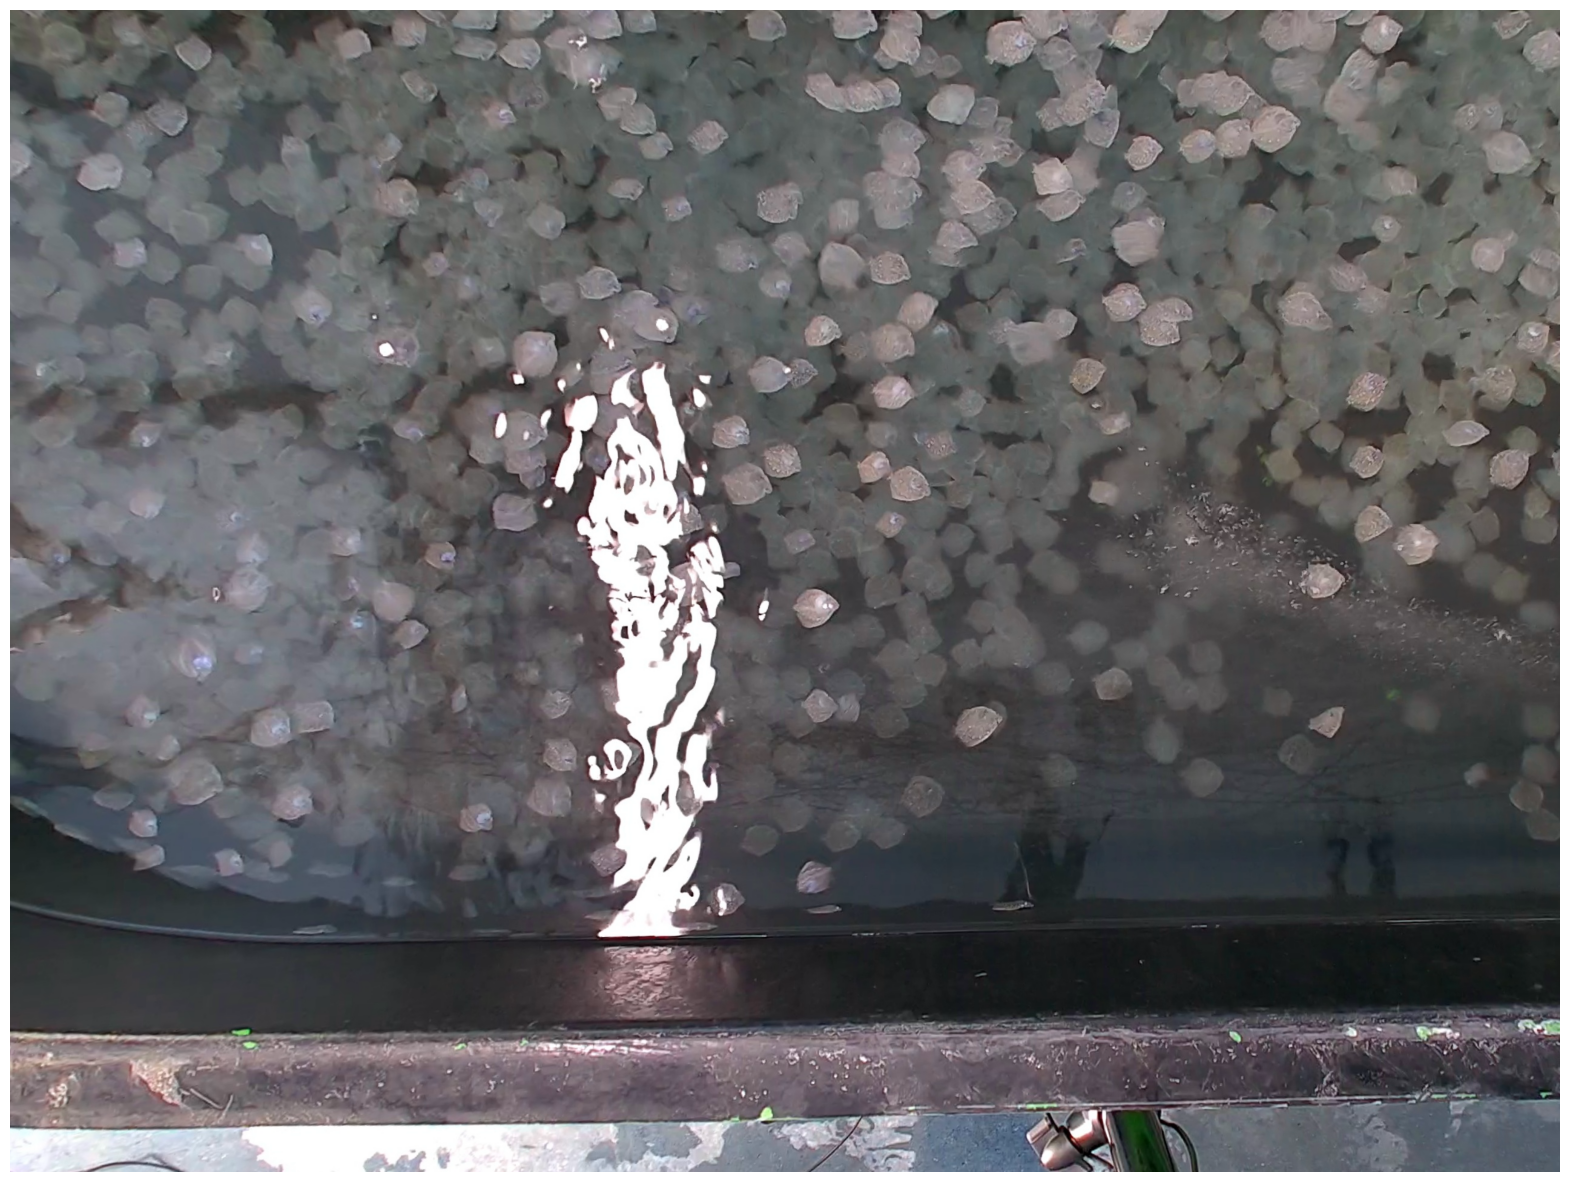

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
if 'google.colab' in sys.modules:
    !pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import sys
sys.path.append("..")
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/content/mobile_sam.pt"
model_type = "vit_t"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam.eval()

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=15,  # Requires open-cv to run post-processing
)

In [ ]:
masks = mask_generator.generate(image)
masks_to_keep = []

for mask in masks: # Añadir el número de cuadrante a cada máscara
    area = mask['area']
    if area <= 4800: #Se filtran por area
        masks_to_keep.append(mask)

KeyboardInterrupt: 

In [ ]:
masks_to_keep = remove_overlapped_masks(masks_to_keep, 0.2)

In [ ]:
len(masks_to_keep)

515

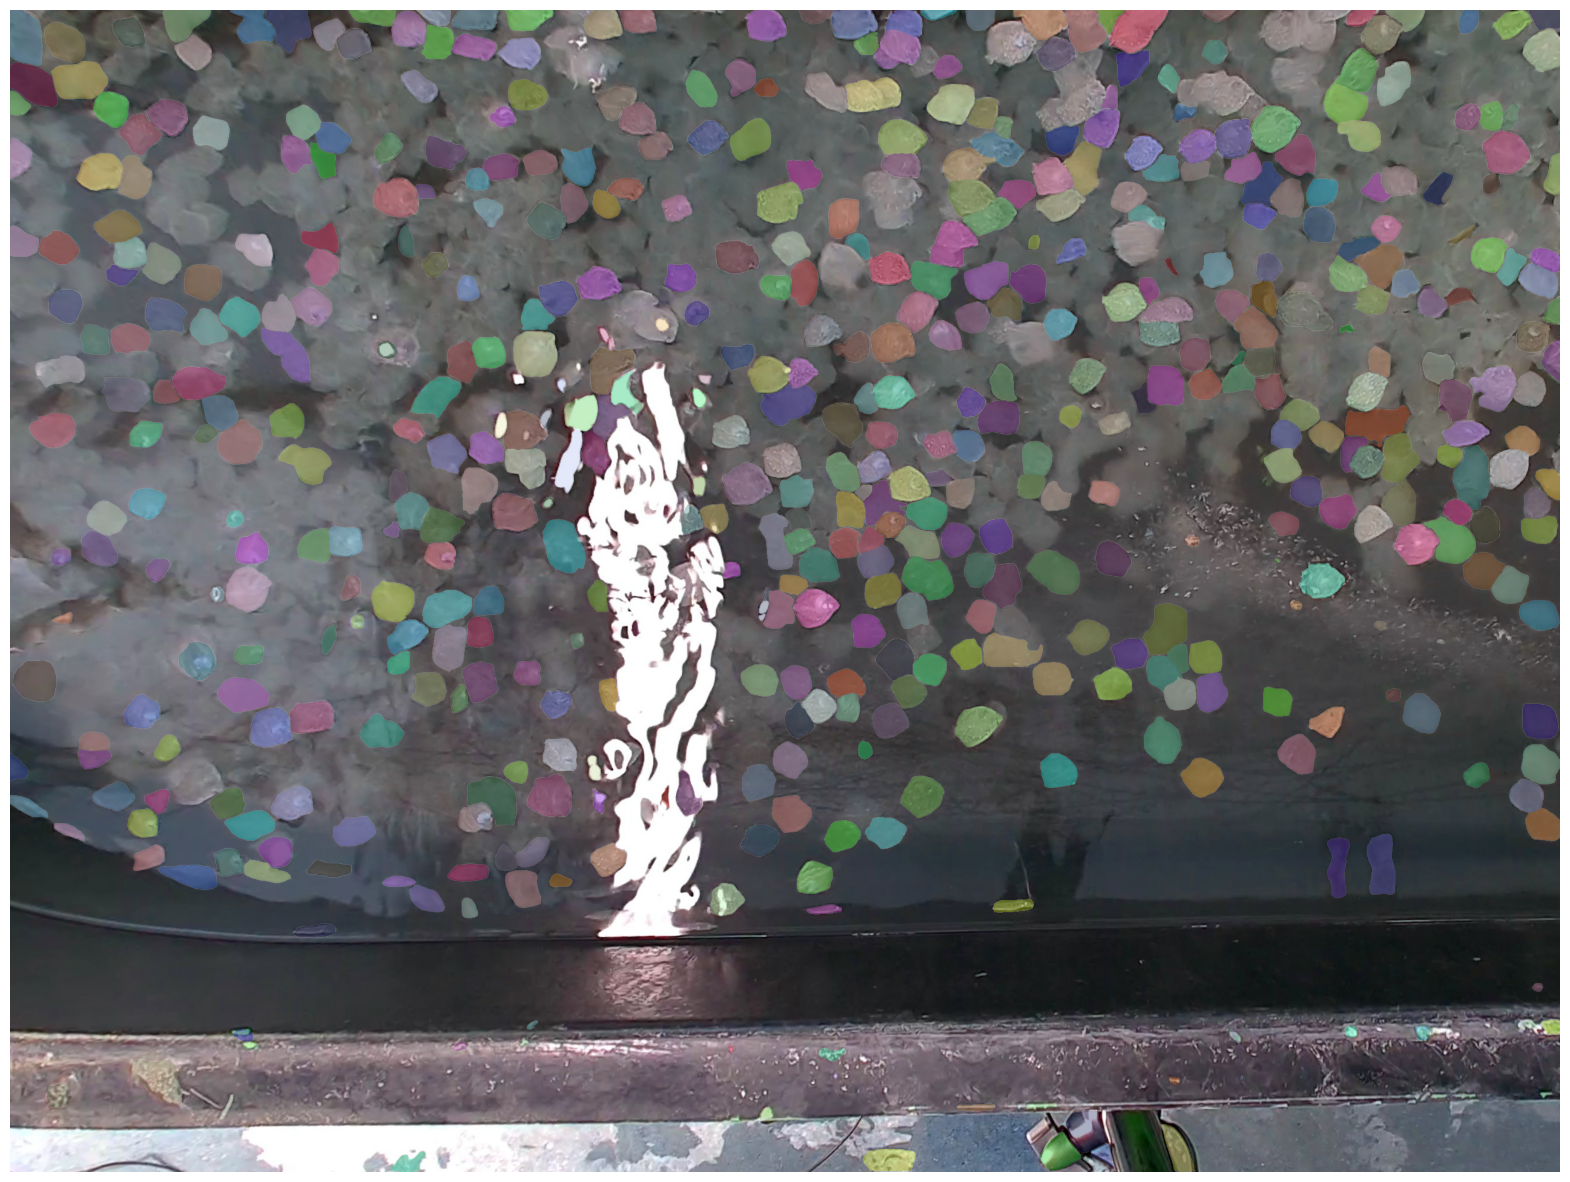

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks_to_keep)
plt.axis('off')
plt.show()

In [ ]:
import json
import os

sufijo = int(image_name.split('_')[-1].split('.')[0])

# Lista de bounding boxes y áreas para las máscaras del lado izquierdo
mask_list = []
for mask in masks_to_keep:
    mask_list.append({
        'bbox': mask['bbox'],
    })

#Guardar los datos de las máscaras en un .json
with open(f'/content/masks_{sufijo}.json', 'w') as archivo_json:
    json.dump(mask_list, archivo_json, default=convertir_a_json, indent=4)